# Aproximación clásica

Este cuaderno implementa una aproximación metodológica clásica para la clasificación de textos, siguiendo un flujo de trabajo estándar en el aprendizaje automático. El objetivo principal es predecir la revista (`journal_id`) a la que pertenece un texto basándose únicamente en su contenido textual. El proceso comienza con la carga de los datos procesados, asegurando la integridad de los tipos de datos. Posteriormente, se procede a la fase crucial de representación vectorial del texto, donde los documentos se transforman en datos numéricos mediante la creación de una matriz de términos-documentos utilizando la técnica TF-IDF (`TfidfVectorizer`), lo que permite a los algoritmos de clasificación interpretar los datos.

## Imports y configuración

Este bloque de código realiza la acción fundamental en cualquier script de Python que utiliza librerías externas: la importación de módulos y funciones necesarios para que el resto del programa funcione.

A continuación, se detalla qué se importa y para qué se usará cada elemento en el contexto del proyecto de machine learning que hemos estado analizando:

- `import json`: Se utiliza para trabajar con datos en formato JSON, específicamente para guardar el resumen de métricas del modelo en un archivo metrics_summary.json.

- `from pathlib import Path`: Proporciona una forma moderna y sencilla de manejar rutas de archivos y directorios (como MODELS_DIR y OUT_DIR).

- `import numpy as np`: NumPy es esencial para la computación numérica eficiente. Se usa para trabajar con arrays (ej. np.arange(len(df)), np.unique()) y operaciones matemáticas.

- `import pandas as pd`: Pandas es la biblioteca estándar para el manejo y análisis de datos. Se usa para cargar y manipular el DataFrame (df).

- `import joblib`: Se utiliza para serializar y guardar el modelo de machine learning entrenado (best_model...joblib) en el disco duro.

Scikit-learn es la biblioteca principal para machine learning en Python:

- `from sklearn.model_selection import train_test_split`: La función clave para dividir los datos en conjuntos de entrenamiento y prueba.

- `from sklearn.feature_extraction.text import TfidfVectorizer`: La herramienta utilizada para convertir texto sin formato en datos numéricos (características) que los modelos puedan entender.

- `from sklearn.pipeline import Pipeline`: Permite encadenar pasos de preprocesamiento (TF-IDF) y clasificación en un solo objeto.

- `from sklearn.metrics import classification_report, confusion_matrix`: Funciones esenciales para evaluar el rendimiento de los modelos mediante informes detallados y matrices de confusión.
- `from sklearn.linear_model import LogisticRegression`: El primer algoritmo de clasificación que se utiliza.
- `from sklearn.svm import LinearSVC`: El segundo algoritmo, una Máquina de Vectores de Soporte Lineal.
- `from sklearn.naive_bayes import MultinomialNB`: El tercer algoritmo, Naive Bayes Multinomial.
- `from sklearn.svm import SVC`: Máquina de Vectores de Soporte con kernel RBF (Radial Basis Function), que permite modelar relaciones no lineales entre características. Es más flexible que LinearSVC pero computacionalmente más costoso.

**Imbalanced-learn** (imblearn) para manejar el desequilibrio de clases:

- `from imblearn.over_sampling import SMOTE`: SMOTE (Synthetic Minority Over-sampling Technique) genera ejemplos sintéticos de las clases minoritarias mediante interpolación, balanceando el dataset de entrenamiento.
- `from imblearn.pipeline import Pipeline as ImbPipeline`: Extensión del Pipeline de scikit-learn que soporta técnicas de resampling como SMOTE. Se importa con alias para evitar conflictos de nombres con el Pipeline estándar.

Además, se emplean `matplotlib` y `seaborn` como librerías para graficar resultados (plots y heatmaps) en el cuaderno.

In [43]:
import json
from pathlib import Path

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

import joblib

import matplotlib.pyplot as plt
import seaborn as sns

## Carga del dataset

En esta parte, se hace la carga inicial y preparación básica del conjunto de datos (dataset) antes de que comience cualquier proceso de modelado o entrenamiento de machine learning.

`df.shape` muestra las dimensiones del dataframe (número de filas y columnas), que actualmente son 17,468 registros repartidos en 9 características distintas, y `df["journal_id"].value_counts().sort_index()` proporciona un resumen de cuántos registros hay para cada valor único de `journal_id`. Esto permite ver si las clases están equilibradas o si existe un desequilibrio de clases que podría afectar a los modelos.

In [44]:
DATASET_PATH = Path("../data/processed/dataset.csv")
df = pd.read_csv(DATASET_PATH)

# Asegurar tipos
df["journal_id"] = df["journal_id"].astype(int)
df["text"] = df["text"].fillna("").astype(str)

df.shape, df["journal_id"].value_counts().sort_index()

((17468, 9),
 journal_id
 1    1083
 2    2331
 3    9589
 5    4465
 Name: count, dtype: int64)

## Split estratificado

*Split* es el proceso de dividir o particionar un conjunto de datos grande, nuestro dataset, en subconjuntos más pequeños y manejables.

El código realiza los siguientes *splits* (divisiones):

- X_train, X_test: divide los datos de entrada (los textos, X) en partes de entrenamiento y prueba.

- y_train, y_test: divide las etiquetas u objetivos (los IDs de las revistas, y) de forma correspondiente a los textos.

- idx_train, idx_test: divide los índices originales del DataFrame, lo que permite rastrear a qué fila pertenecía cada registro en el conjunto de datos original, incluso después de la división aleatoria.

La función *train_test_split* maneja todo el proceso de dividir y mezclar los datos de manera aleatoria pero reproducible (gracias a random_state=42) y equilibrada (gracias a stratify=y).

Posteriormente, *len(X_train)* representa el número total de ejemplos (filas) en el conjunto de entrenamiento. Por tanto, hay 13,974 textos que el modelo utilizará para aprender durante el proceso de entrenamiento.

*len(X_test)* es el número total de ejemplos (filas) en el conjunto de prueba. Hay 3,494 textos que se usarán para evaluar el rendimiento del modelo una vez que haya terminado de entrenar. 

Si se suman 13,974 + 3,494, se obtiene un total de 17,468 filas en el DataFrame original. 3,494 representa exactamente el 20% de ese total, lo cual confirma que test_size=0.2 funcionó correctamente.

*np.unique(y_train, return_counts=True)* da un resumen de las clases (los journal_id) y cuántas veces aparece cada una en el conjunto de entrenamiento. El resultado array([1, 2, 3, 5]) son los valores únicos (los IDs de las revistas) que existen en los datos de entrenamiento. Hay 4 categorías o clases distintas. array([ 866, 1865, 7671, 3572]) es el recuento (la frecuencia) de cada clase correspondiente en el mismo orden que el array anterior. Por ejemplo, la revista 1 aparece 866 veces en *y_train*, la 2 aparece 1,865, y así sucesivamente.

In [45]:
X = df["text"].values
y = df["journal_id"].values

X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
    X, y, np.arange(len(df)),
    test_size=0.2,
    random_state=42,
    stratify=y
)

len(X_train), len(X_test), np.unique(y_train, return_counts=True)

(13974, 3494, (array([1, 2, 3, 5]), array([ 866, 1865, 7671, 3572])))

## Definición de modelos (TF‑IDF + clasificador)

### Sin `class_weight`

#### Análisis del impacto de SMOTE

En este bloque de código se realiza el proceso central del proyecto: la vectorización de los textos, la creación de modelos de clasificación y el entrenamiento y evaluación de los mismos.

Se están preparando y probando tres modelos de clasificación diferentes para determinar cuál funciona mejor para predecir el `journal_id` basándose en el texto (`X_train`, `y_train`).

Se define un objeto `TfidfVectorizer`. Esta herramienta es crucial porque los modelos de machine learning no pueden leer texto directamente; necesitan números. El vectorizador convierte la colección de textos en una matriz numérica.

Los parámetros configuran cómo se hace esta conversión:

- `lowercase=True`: convierte todo el texto a minúsculas.

- `stop_words="english"`: elimina palabras comunes en inglés que no suelen aportar significado para la clasificación (ej. "a", "the", "is", "on").

- `ngram_range=(1, 2)`: considera palabras individuales (unigramas) y pares de palabras consecutivas (bigramas) como características.

- `min_df=2`: ignora los términos que aparecen en menos de 2 documentos.

- `max_df=0.95`: ignora los términos que aparecen en más del 95% de los documentos (palabras demasiado comunes que tampoco discriminan).

Se crea un diccionario llamado models que contiene tres algoritmos de clasificación diferentes:

- `logreg`: regresión Logística (popular para clasificación de texto).

- `linear_svm`: máquina de Vectores de Soporte Lineal (SVC), muy potente para texto.

- `mnb`: Multinomial Naive Bayes, un modelo probabilístico clásico y eficiente para datos de texto (conteo de palabras).

Se utiliza un `Pipeline` para encadenar dos pasos:

- `tfidf`: el vectorizador que definimos antes.

- `clf`: el clasificador (modelo) correspondiente de la lista anterior.

Esto es muy eficiente porque permite aplicar el preprocesamiento (`tfidf`) y el entrenamiento del modelo (`clf`) en una sola llamada. Se crean tres pipelines diferentes, uno para cada modelo.

Posteriormente, se ejecuta el proceso para cada uno de los tres pipelines creados:

- `pipeline.fit(X_train, y_train)`: el modelo se entrena utilizando los datos de entrenamiento (`X_train` y `y_train`). Durante este paso, el vectorizador `tfidf` aprende el vocabulario de los textos y el clasificador aprende a asociar patrones de palabras con los `journal_id`.

- `y_pred = pipeline.predict(X_test)`: una vez entrenado, el modelo se usa para predecir los IDs de revista para el conjunto de prueba (`X_test`), datos que el modelo no había visto antes.

- `classification_report(y_test, y_pred)`: se evalúa el rendimiento comparando las predicciones del modelo (`y_pred`) con las etiquetas reales (`y_test`). Esto imprime métricas clave como `Precision`, `Recall` y `F1-score` para cada clase.

- `confusion_matrix(y_test, y_pred)`: se imprime la matriz de confusión, que muestra visualmente cuántas veces acertó el modelo para cada clase y en cuáles se equivocó.

En este bloque, se está configurando y ejecutando un experimento comparativo para ver cuál de los tres algoritmos (Regresión Logística, SVM Lineal o Naive Bayes) es el más preciso para clasificar los textos según el ID de la revista.

In [37]:
tfidf = TfidfVectorizer(
    lowercase=True,
    stop_words="english",
    ngram_range=(1, 2),
    min_df=2,
    max_df=0.95
)

models = {
    "logreg": LogisticRegression(max_iter=2000, n_jobs=None),
    "linear_svm": LinearSVC(),
    "mnb": MultinomialNB(),
}

pipelines = {
    name: Pipeline([("tfidf", tfidf), ("clf", clf)])
    for name, clf in models.items()
}

pipelines
for name, pipeline in pipelines.items():
    print(f"Training {name}...")
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    print(f"Results for {name}:")
    print(classification_report(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))

Training logreg...
Results for logreg:
              precision    recall  f1-score   support

           1       0.99      0.86      0.92       217
           2       0.78      0.42      0.55       466
           3       0.79      0.90      0.84      1918
           5       0.67      0.65      0.66       893

    accuracy                           0.77      3494
   macro avg       0.81      0.71      0.74      3494
weighted avg       0.77      0.77      0.76      3494

[[ 187    0   29    1]
 [   0  197  152  117]
 [   2   20 1729  167]
 [   0   37  274  582]]
Training linear_svm...
Results for linear_svm:
              precision    recall  f1-score   support

           1       0.97      0.95      0.96       217
           2       0.72      0.49      0.58       466
           3       0.82      0.88      0.85      1918
           5       0.67      0.67      0.67       893

    accuracy                           0.78      3494
   macro avg       0.79      0.75      0.77      3494
weight

## Entrenar y evaluar (classification_report + confusión)

Este bloque de código es muy similar al anterior, pero optimizado para almacenar y organizar los resultados de la evaluación de cada modelo en un diccionario llamado results.

El objetivo principal de este fragmento es: entrenar sistemáticamente cada uno de los pipelines definidos anteriormente, evaluar su rendimiento utilizando datos de prueba y guardar los objetos del pipeline, el informe de clasificación y la matriz de confusión para su posterior análisis.

Se crea un diccionario vacío `results` donde se almacenarán todos los datos relevantes para cada modelo (logistic regression, SVM, Naive Bayes).

Luego, itera sobre cada par (nombre_modelo, objeto_pipeline) del diccionario pipelines que se definió en el código anterior. Con `pipe.fit(X_train, y_train)` entrena el pipeline actual (que incluye la vectorización TF-IDF y el clasificador) usando los datos de entrenamiento. `y_pred = pipe.predict(X_test)` utiliza el modelo recién entrenado para hacer predicciones sobre los textos del conjunto de prueba (`X_test`), que el modelo no ha visto antes. `classification_report` calcula métricas de rendimiento (precisión, recall, F1-score, soporte) comparando las etiquetas reales (`y_test`) con las predichas (`y_pred`). Se especifica `output_dict=True` para guardar los resultados como un diccionario estructurado (fácil de manipular más tarde) y `zero_division=0` para evitar errores si alguna clase no tiene predicciones. `confusion_matrix` calcula la matriz de confusión, que detalla los aciertos y errores por clase.

Por último, se almacenan los resultados de este modelo específico en el diccionario `results`, indexado por el nombre del modelo (ej. "logreg", "linear_svm", "mnb"), y se imprime de forma legible y estructurada el nombre del modelo, el informe de clasificación completo y la matriz de confusión directamente en la consola para una revisión inmediata mientras se ejecuta el código.

El código anterior solo imprimía los resultados en la consola. Este código hace lo mismo, pero además guarda todos los objetos y métricas en el diccionario results, permitiendo que el científico de datos acceda posteriormente al mejor modelo entrenado (`results["linear_svm"]["pipeline"]`) o a las métricas específicas sin tener que volver a ejecutar el entrenamiento.

In [ ]:
results = {}

for name, pipe in pipelines.items():
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    rep = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
    cm = confusion_matrix(y_test, y_pred)

    results[name] = {
        "pipeline": pipe,
        "report": rep,
        "cm": cm
    }

    print("\n===", name, "===")
    print(classification_report(y_test, y_pred, zero_division=0))
    print("Confusion matrix:\n", cm)


=== logreg ===
              precision    recall  f1-score   support

           1       0.99      0.86      0.92       217
           2       0.78      0.42      0.55       466
           3       0.79      0.90      0.84      1918
           5       0.67      0.65      0.66       893

    accuracy                           0.77      3494
   macro avg       0.81      0.71      0.74      3494
weighted avg       0.77      0.77      0.76      3494

Confusion matrix:
 [[ 187    0   29    1]
 [   0  197  152  117]
 [   2   20 1729  167]
 [   0   37  274  582]]

=== linear_svm ===
              precision    recall  f1-score   support

           1       0.97      0.95      0.96       217
           2       0.72      0.49      0.58       466
           3       0.82      0.88      0.85      1918
           5       0.67      0.67      0.67       893

    accuracy                           0.78      3494
   macro avg       0.79      0.75      0.77      3494
weighted avg       0.78      0.78    

### Solución al desequilibrio de clases

El dataset presenta un **desequilibrio significativo**: la revista 3 tiene 7,671 ejemplos mientras que la revista 1 solo tiene 866. Esto causa que los modelos favorezcan a la clase mayoritaria.

**Soluciones implementadas:**

1. **`class_weight='balanced'`**: ajusta automáticamente los pesos de las clases de forma inversamente proporcional a su frecuencia, penalizando más los errores en clases minoritarias.

2. **Evaluación con Macro F1-score**: esta métrica da el mismo peso a todas las clases independientemente de su tamaño, reflejando mejor el rendimiento real en datasets desequilibrados.

3. **Sobremuestreo (SMOTE)**: permite aumentar ejemplos de las clases minoritarias.

In [42]:
def macro_f1(res):
    return res["report"]["macro avg"]["f1-score"]

# Modelos con class_weight='balanced' para manejar desequilibrio de clases
tfidf_balanced = TfidfVectorizer(
    lowercase=True,
    stop_words="english",
    ngram_range=(1, 2),
    min_df=2,
    max_df=0.95
)

# =============================================================================
# 1. MODELOS CON class_weight='balanced' (SIN SMOTE)
# =============================================================================
pipelines_balanced = {
    "logreg_balanced": Pipeline([
        ("tfidf", tfidf_balanced),
        ("clf", LogisticRegression(max_iter=2000, class_weight="balanced"))
    ]),
    "linear_svm_balanced": Pipeline([
        ("tfidf", tfidf_balanced),
        ("clf", LinearSVC(class_weight="balanced"))
    ]),
    # NB naturalmente robusto al desequilibrio, no tiene class_weight
    "mnb": Pipeline([
        ("tfidf", tfidf_balanced),
        ("clf", MultinomialNB())
    ]),
}

results_balanced = {}

print("="*70)
print("ENTRENAMIENTO CON class_weight='balanced' (SIN SMOTE)")
print("="*70)

for name, pipe in pipelines_balanced.items():
    print(f"\nTraining {name}...")
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    rep = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
    cm = confusion_matrix(y_test, y_pred)

    results_balanced[name] = {
        "pipeline": pipe,
        "report": rep,
        "cm": cm
    }

    print(f"Results for {name}:")
    print(classification_report(y_test, y_pred, zero_division=0))
    print("Confusion matrix:\n", cm)

# =============================================================================
# 2. MODELOS CON SMOTE (SIN class_weight) - MOVER AQUÍ ANTES
# =============================================================================
tfidf_smote = TfidfVectorizer(
    lowercase=True,
    stop_words="english",
    ngram_range=(1, 2),
    min_df=2,
    max_df=0.95
)

pipelines_smote = {
    "logreg_smote": ImbPipeline([
        ("tfidf", tfidf_smote),
        ("smote", SMOTE(random_state=42)),
        ("clf", LogisticRegression(max_iter=2000))
    ]),
    "linear_svm_smote": ImbPipeline([
        ("tfidf", tfidf_smote),
        ("smote", SMOTE(random_state=42)),
        ("clf", LinearSVC())
    ]),
    "mnb_smote": ImbPipeline([
        ("tfidf", tfidf_smote),
        ("smote", SMOTE(random_state=42)),
        ("clf", MultinomialNB())
    ]),
}

results_smote = {}

print("\n" + "="*70)
print("ENTRENAMIENTO CON SMOTE (sin class_weight)")
print("="*70)
print("\nSMOTE genera ejemplos sintéticos de clases minoritarias.\n")

for name, pipe in pipelines_smote.items():
    print(f"\nTraining {name}...")
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    rep = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
    cm = confusion_matrix(y_test, y_pred)

    results_smote[name] = {
        "pipeline": pipe,
        "report": rep,
        "cm": cm
    }

    print(f"Results for {name}:")
    print(classification_report(y_test, y_pred, zero_division=0))
    print("Confusion matrix:\n", cm)

# =============================================================================
# 3. MODELOS HÍBRIDOS: class_weight='balanced' + SMOTE
# =============================================================================
pipelines_balanced_smote = {
    "logreg_balanced_smote": ImbPipeline([
        ("tfidf", tfidf_balanced),
        ("smote", SMOTE(random_state=42)),
        ("clf", LogisticRegression(max_iter=2000, class_weight="balanced"))
    ]),
    "linear_svm_balanced_smote": ImbPipeline([
        ("tfidf", tfidf_balanced),
        ("smote", SMOTE(random_state=42)),
        ("clf", LinearSVC(class_weight="balanced"))
    ]),
    # NB con SMOTE (sin class_weight porque no lo soporta)
    "mnb_balanced_smote": ImbPipeline([
        ("tfidf", tfidf_balanced),
        ("smote", SMOTE(random_state=42)),
        ("clf", MultinomialNB())
    ]),
}

results_balanced_smote = {}

print("\n" + "="*70)
print("ENTRENAMIENTO HÍBRIDO: class_weight='balanced' + SMOTE")
print("="*70)
print("\nCombinando sobremuestreo sintético (SMOTE) con pesos de clase ajustados.\n")

for name, pipe in pipelines_balanced_smote.items():
    print(f"\nTraining {name}...")
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    rep = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
    cm = confusion_matrix(y_test, y_pred)

    results_balanced_smote[name] = {
        "pipeline": pipe,
        "report": rep,
        "cm": cm
    }

    print(f"Results for {name}:")
    print(classification_report(y_test, y_pred, zero_division=0))
    print("Confusion matrix:\n", cm)

# =============================================================================
# 4. COMPARACIÓN COMPLETA DE TODOS LOS ENFOQUES
# =============================================================================
print("\n" + "="*70)
print("COMPARACIÓN MACRO F1-SCORE: TODOS LOS ENFOQUES")
print("="*70)

print("\n1. Modelos SIN balanceo:")
for name in results.keys():
    print(f"  {name:30s}: {macro_f1(results[name]):.4f}")

print("\n2. Modelos CON class_weight='balanced':")
for name in results_balanced.keys():
    print(f"  {name:30s}: {macro_f1(results_balanced[name]):.4f}")

print("\n3. Modelos CON SMOTE (sin class_weight):")
for name in results_smote.keys():
    print(f"  {name:30s}: {macro_f1(results_smote[name]):.4f}")

print("\n4. Modelos HÍBRIDOS (class_weight + SMOTE):")
for name in results_balanced_smote.keys():
    print(f"  {name:30s}: {macro_f1(results_balanced_smote[name]):.4f}")

# =============================================================================
# 5. RESUMEN Y MEJOR MODELO GLOBAL
# =============================================================================
print("\n" + "="*70)
print("RESUMEN DE ENFOQUES:")
print("="*70)

all_approaches = {
    **{k: ("Sin balanceo", v) for k, v in results.items()},
    **{k: ("class_weight", v) for k, v in results_balanced.items()},
    **{k: ("SMOTE", v) for k, v in results_smote.items()},
    **{k: ("SMOTE+class_weight", v) for k, v in results_balanced_smote.items()}
}

best_overall = max(all_approaches.items(), key=lambda x: macro_f1(x[1][1]))
print(f"\n🏆 MEJOR MODELO GLOBAL: {best_overall[0]}")
print(f"   Enfoque: {best_overall[1][0]}")
print(f"   Macro F1-score: {macro_f1(best_overall[1][1]):.4f}")

# Top 5 modelos
print("\n" + "="*70)
print("TOP 5 MODELOS:")
print("="*70)
sorted_models = sorted(all_approaches.items(), key=lambda x: macro_f1(x[1][1]), reverse=True)[:5]
for rank, (name, (approach, res)) in enumerate(sorted_models, 1):
    print(f"{rank}. {name:30s} [{approach:20s}] - Macro F1: {macro_f1(res):.4f}")

ENTRENAMIENTO CON class_weight='balanced' (SIN SMOTE)

Training logreg_balanced...
Results for logreg_balanced:
              precision    recall  f1-score   support

           1       0.90      0.99      0.94       217
           2       0.56      0.64      0.60       466
           3       0.89      0.78      0.83      1918
           5       0.63      0.72      0.67       893

    accuracy                           0.76      3494
   macro avg       0.74      0.78      0.76      3494
weighted avg       0.78      0.76      0.77      3494

Confusion matrix:
 [[ 215    0    2    0]
 [   0  299   56  111]
 [  23  126 1500  269]
 [   2  109  135  647]]

Training linear_svm_balanced...
Results for linear_svm_balanced:
              precision    recall  f1-score   support

           1       0.95      0.96      0.96       217
           2       0.65      0.54      0.59       466
           3       0.85      0.86      0.85      1918
           5       0.66      0.69      0.68       893

   

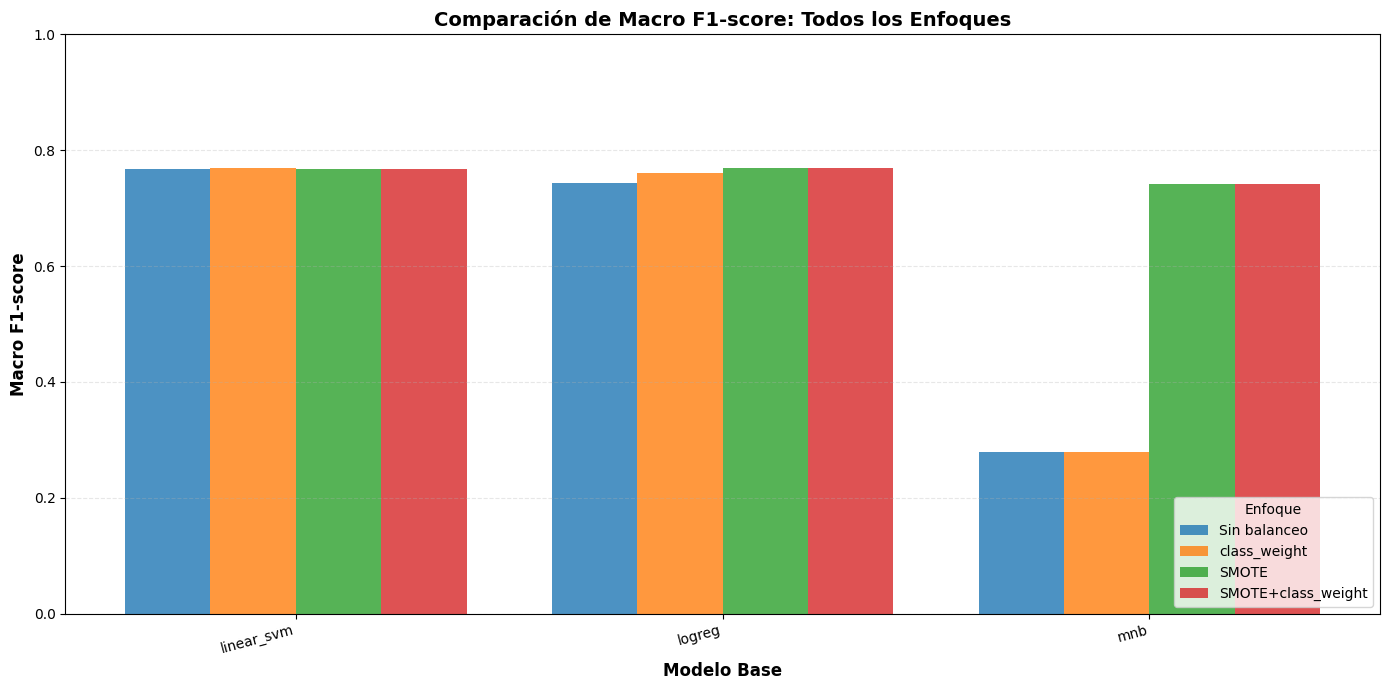

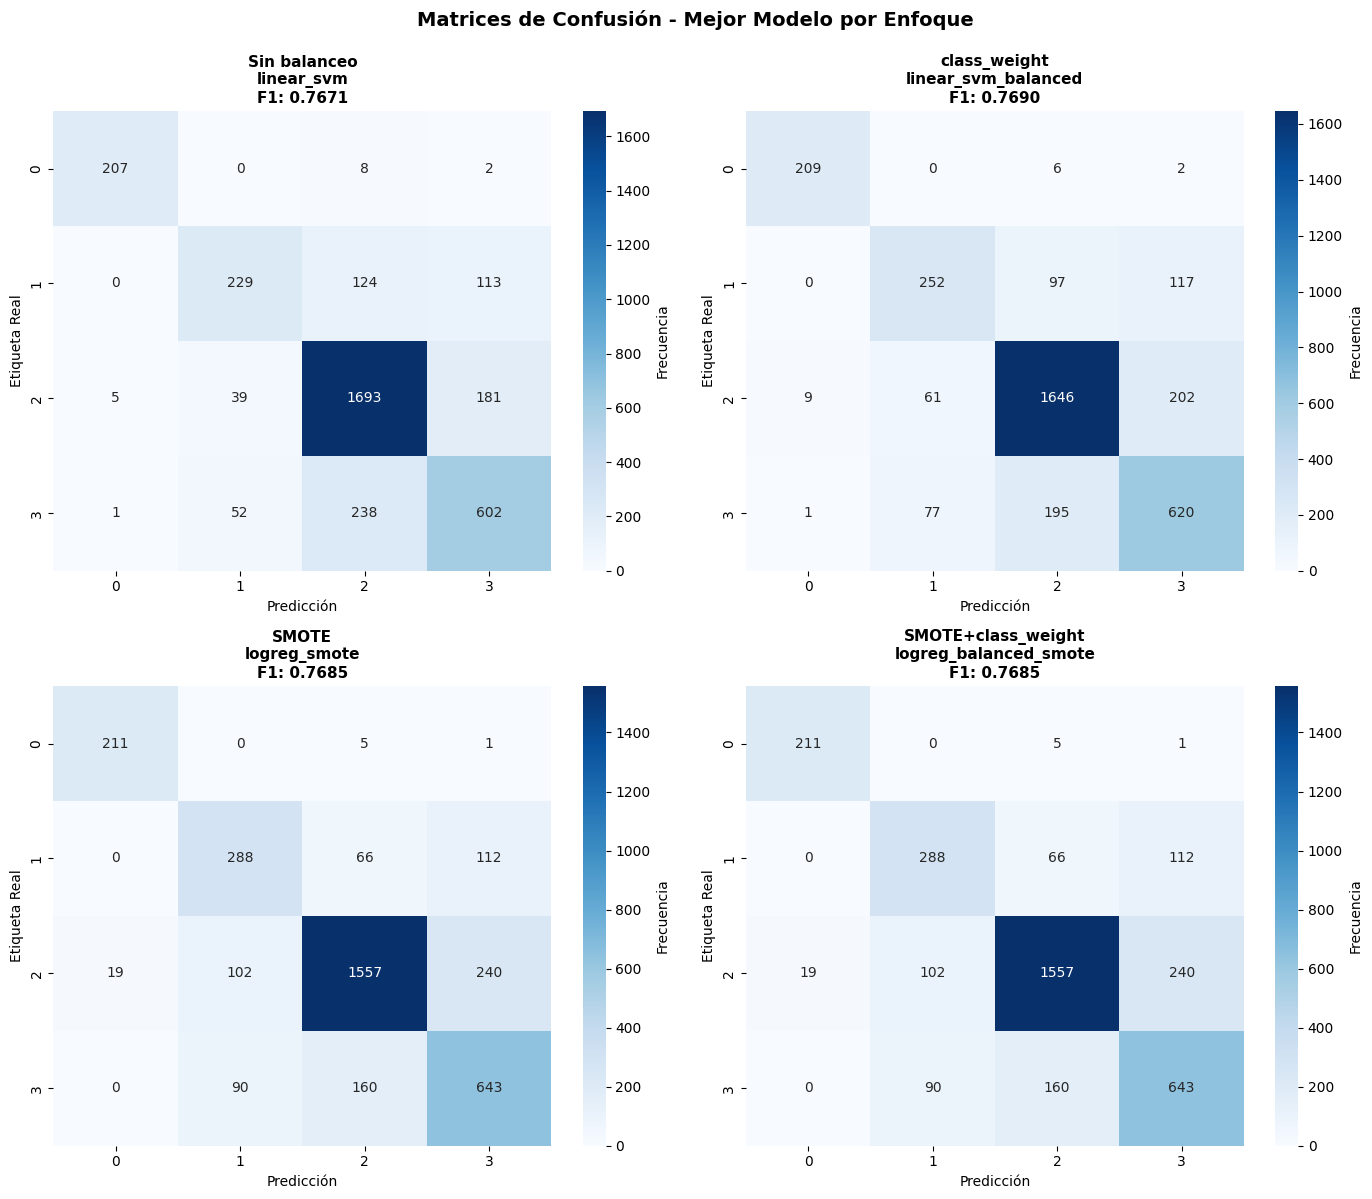

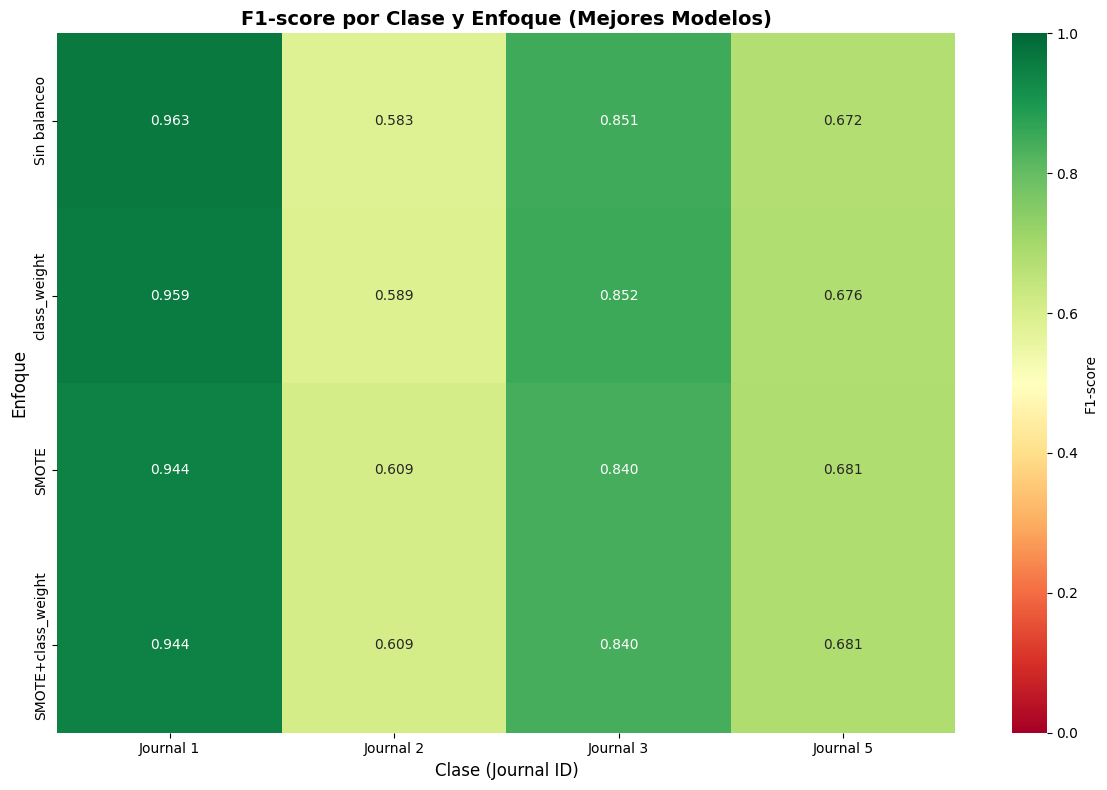

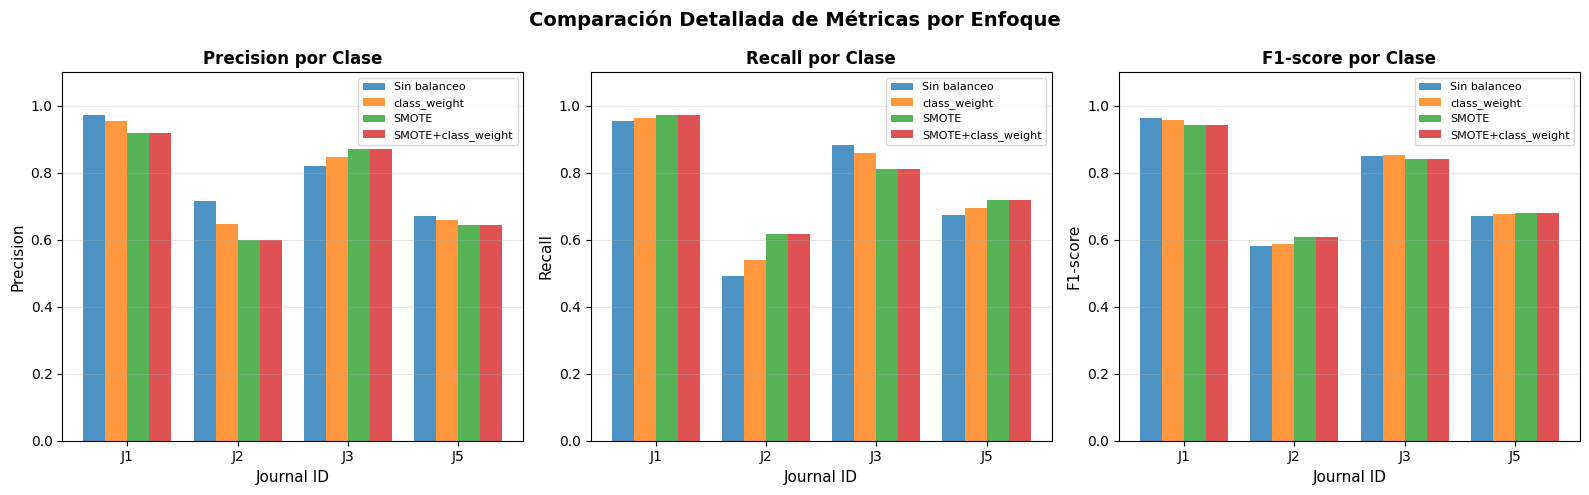


RESUMEN ESTADÍSTICO POR ENFOQUE

Sin balanceo:
  Promedio Macro F1: 0.5962
  Mejor Macro F1:    0.7671
  Peor Macro F1:     0.2785
  Desv. Estándar:    0.2249

class_weight:
  Promedio Macro F1: 0.6028
  Mejor Macro F1:    0.7690
  Peor Macro F1:     0.2785
  Desv. Estándar:    0.2294

SMOTE:
  Promedio Macro F1: 0.7594
  Mejor Macro F1:    0.7685
  Peor Macro F1:     0.7420
  Desv. Estándar:    0.0123

SMOTE+class_weight:
  Promedio Macro F1: 0.7594
  Mejor Macro F1:    0.7685
  Peor Macro F1:     0.7420
  Desv. Estándar:    0.0123


In [47]:
# 1. Comparación de Macro F1-score por enfoque y modelo
fig, ax = plt.subplots(figsize=(14, 7))

approaches_dict = {
    'Sin balanceo': results,
    'class_weight': results_balanced,
    'SMOTE': results_smote,
    'SMOTE+class_weight': results_balanced_smote
}

base_models = set()
for res_dict in approaches_dict.values():
    for name in res_dict.keys():
        base = name.replace('_balanced', '').replace('_smote', '')
        base_models.add(base)

base_models = sorted(base_models)
approaches_names = list(approaches_dict.keys())

x = np.arange(len(base_models))
width = 0.2
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

for i, (approach_name, results_dict) in enumerate(approaches_dict.items()):
    scores = []
    for base in base_models:
        score = None
        for model_name, res in results_dict.items():
            if base in model_name or model_name == base:
                score = macro_f1(res)
                break
        scores.append(score if score is not None else 0)
    
    offset = width * (i - 1.5)
    ax.bar(x + offset, scores, width, label=approach_name, color=colors[i], alpha=0.8)

ax.set_xlabel('Modelo Base', fontsize=12, fontweight='bold')
ax.set_ylabel('Macro F1-score', fontsize=12, fontweight='bold')
ax.set_title('Comparación de Macro F1-score: Todos los Enfoques', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(base_models, rotation=15, ha='right')
ax.legend(title='Enfoque', loc='lower right')
ax.set_ylim([0, 1])
ax.grid(axis='y', alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

# 2. Matrices de confusión de los mejores modelos por enfoque
fig, axes = plt.subplots(2, 2, figsize=(14, 12))
axes = axes.flatten()

for idx, (approach_name, results_dict) in enumerate(approaches_dict.items()):
    # Encontrar mejor modelo en este enfoque
    best_in_approach = max(results_dict.items(), key=lambda x: macro_f1(x[1]))
    best_name_approach = best_in_approach[0]
    cm = best_in_approach[1]['cm']
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[idx], 
                cbar_kws={'label': 'Frecuencia'})
    axes[idx].set_title(f'{approach_name}\n{best_name_approach}\nF1: {macro_f1(best_in_approach[1]):.4f}', 
                       fontsize=11, fontweight='bold')
    axes[idx].set_ylabel('Etiqueta Real', fontsize=10)
    axes[idx].set_xlabel('Predicción', fontsize=10)

plt.suptitle('Matrices de Confusión - Mejor Modelo por Enfoque', 
             fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

# 3. Heatmap de F1-score por clase y enfoque
fig, ax = plt.subplots(figsize=(12, 8))

# Recopilar F1-scores por clase para cada enfoque
classes = sorted(set(y_test))
heatmap_data = []

for approach_name, results_dict in approaches_dict.items():
    best_in_approach = max(results_dict.items(), key=lambda x: macro_f1(x[1]))
    report = best_in_approach[1]['report']
    
    f1_scores = [report[str(c)]['f1-score'] if str(c) in report else 0 
                 for c in classes]
    heatmap_data.append(f1_scores)

sns.heatmap(heatmap_data, annot=True, fmt='.3f', cmap='RdYlGn', 
            xticklabels=[f'Journal {c}' for c in classes],
            yticklabels=approaches_names,
            vmin=0, vmax=1, ax=ax, cbar_kws={'label': 'F1-score'})
ax.set_title('F1-score por Clase y Enfoque (Mejores Modelos)', 
             fontsize=14, fontweight='bold')
ax.set_xlabel('Clase (Journal ID)', fontsize=12)
ax.set_ylabel('Enfoque', fontsize=12)
plt.tight_layout()
plt.show()

# 4. Comparación detallada: Precision, Recall, F1 del mejor modelo global
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

metrics_names = ['precision', 'recall', 'f1-score']
report_best = all_approaches[best_overall[0]][1]['report']

for idx, metric in enumerate(metrics_names):
    scores_by_approach = {approach: [] for approach in approaches_names}
    
    for approach_name, results_dict in approaches_dict.items():
        best_in_approach = max(results_dict.items(), key=lambda x: macro_f1(x[1]))
        report = best_in_approach[1]['report']
        
        for c in classes:
            if str(c) in report:
                scores_by_approach[approach_name].append(report[str(c)][metric])
            else:
                scores_by_approach[approach_name].append(0)
    
    x_pos = np.arange(len(classes))
    bar_width = 0.2
    
    for i, approach_name in enumerate(approaches_names):
        offset = bar_width * (i - 1.5)
        axes[idx].bar(x_pos + offset, scores_by_approach[approach_name], 
                     bar_width, label=approach_name, alpha=0.8, color=colors[i])
    
    axes[idx].set_xlabel('Journal ID', fontsize=11)
    axes[idx].set_ylabel(metric.capitalize(), fontsize=11)
    axes[idx].set_title(f'{metric.capitalize()} por Clase', fontsize=12, fontweight='bold')
    axes[idx].set_xticks(x_pos)
    axes[idx].set_xticklabels([f'J{c}' for c in classes])
    axes[idx].set_ylim([0, 1.1])
    axes[idx].legend(fontsize=8)
    axes[idx].grid(axis='y', alpha=0.3)

plt.suptitle('Comparación Detallada de Métricas por Enfoque', 
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# 5. Resumen estadístico
print("\n" + "="*70)
print("RESUMEN ESTADÍSTICO POR ENFOQUE")
print("="*70)

for approach_name, results_dict in approaches_dict.items():
    print(f"\n{approach_name}:")
    f1_scores = [macro_f1(res) for res in results_dict.values()]
    print(f"  Promedio Macro F1: {np.mean(f1_scores):.4f}")
    print(f"  Mejor Macro F1:    {np.max(f1_scores):.4f}")
    print(f"  Peor Macro F1:     {np.min(f1_scores):.4f}")
    print(f"  Desv. Estándar:    {np.std(f1_scores):.4f}")

Además de los modelos lineales, se prueba **SVC con kernel RBF** (Radial Basis Function), que permite capturar relaciones no lineales entre características. Se implementan tres variantes:

1. **`svc_rbf`**: SVC con kernel RBF sin balanceo de clases.
2. **`svc_rbf_balanced`**: SVC con kernel RBF y `class_weight='balanced'`.
3. **`svc_rbf_smote`**: SVC con kernel RBF combinado con sobremuestreo SMOTE.

No obstante, el entrenamiento de SVC con kernel RBF es computacionalmente muy costoso, especialmente con datasets grandes. Puede tardar desde varios minutos hasta horas, dependiendo del tamaño del conjunto de datos y la potencia del hardware.

**Consideraciones**:
- El kernel RBF es más flexible que los modelos lineales, pero también más propenso al sobreajuste.
- Requiere significativamente más tiempo de entrenamiento y memoria que `LinearSVC`.
- Los resultados se almacenan en `results_svc` y se comparan con todos los demás enfoques para identificar el mejor modelo global.

In [ ]:
# Modelos con SVC (kernel RBF)
pipelines_svc = {
    "svc_rbf": Pipeline([
        ("tfidf", tfidf),
        ("clf", SVC(kernel='rbf', random_state=42))
    ]),
    "svc_rbf_balanced": Pipeline([
        ("tfidf", tfidf_balanced),
        ("clf", SVC(kernel='rbf', class_weight='balanced', random_state=42))
    ]),
}

# O con SMOTE
pipelines_svc_smote = {
    "svc_rbf_smote": ImbPipeline([
        ("tfidf", tfidf_smote),
        ("smote", SMOTE(random_state=42)),
        ("clf", SVC(kernel='rbf', random_state=42))
    ]),
}

# Entrenar y evaluar modelos SVC
print("⚠️ ADVERTENCIA: SVC con kernel RBF puede tardar varios minutos u horas")
results_svc = {}

for name, pipe in pipelines_svc.items():
    print(f"\nTraining {name}... (esto puede tardar)")
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    
    rep = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
    cm = confusion_matrix(y_test, y_pred)
    
    results_svc[name] = {
        "pipeline": pipe,
        "report": rep,
        "cm": cm
    }
    
    print(f"Macro F1-score: {macro_f1(results_svc[name]):.4f}")

⚠️ ADVERTENCIA: SVC con kernel RBF puede tardar varios minutos u horas

Training svc_rbf... (esto puede tardar)
Macro F1-score: 0.7427

Training svc_rbf_balanced... (esto puede tardar)
Macro F1-score: 0.7703


## Elección del mejor modelo (macro F1) y guardarlo

Aquí se define una pequeña función auxiliar que toma un diccionario de resultados (`res`) y extrae el valor específico del f1-score para el promedio macro.

El Macro F1-score es una métrica de evaluación que calcula el F1-score para cada clase de forma independiente y luego promedia esos resultados, dando el mismo peso a cada clase sin importar cuántos ejemplos tenga. Esto es muy útil cuando las clases están desequilibradas.

Luego:

- results.keys(): Obtiene los nombres de los modelos ("logreg", "linear_svm", "mnb").

- max(): Encuentra el elemento máximo de esa lista.
key=lambda n: macro_f1(results[n]): Esta función key le dice a 

- max() que no compare los nombres alfabéticamente, sino que use la función macro_f1 para obtener la puntuación de cada modelo y encuentre el nombre (n) que corresponde a la puntuación más alta.

`best` actúa usando el nombre del mejor modelo identificado. se accede al diccionario results para extraer el objeto pipeline completo que ya está entrenado y listo para ser utilizado en producción o para futuras predicciones.

Luego se imprime una tupla que contiene el nombre del modelo ganador y su puntuación Macro F1-score.

**Actualización**: ahora se comparan tanto los modelos sin balanceo como los modelos balanceados, y se selecciona el mejor entre todos.

In [ ]:
# Combinar resultados de TODOS los enfoques (sin balanceo + class_weight + SMOTE)
all_results = {**results, **results_balanced, **results_smote, **results_svc}

# Seleccionar el mejor entre todos
best_name = max(all_results.keys(), key=lambda n: macro_f1(all_results[n]))
best = all_results[best_name]["pipeline"]

print(f"Mejor modelo: {best_name}")
print(f"Macro F1-score: {macro_f1(all_results[best_name]):.4f}")
print(f"\nDetalle del mejor modelo:")
print(classification_report(y_test, best.predict(X_test), zero_division=0))

# Mostrar top 5 modelos
print("\n" + "="*70)
print("TOP 5 MODELOS (todos los enfoques):")
print("="*70)
top_models = sorted(all_results.items(), key=lambda x: macro_f1(x[1]), reverse=True)[:5]
for rank, (name, res) in enumerate(top_models, 1):
    approach = "SMOTE" if "smote" in name else ("class_weight" if "balanced" in name else "sin balance")
    print(f"{rank}. {name:30s} [{approach:15s}] - Macro F1: {macro_f1(res):.4f}")


Mejor modelo: svc_rbf_balanced
Macro F1-score: 0.7703

Detalle del mejor modelo:
              precision    recall  f1-score   support

           1       0.98      0.92      0.95       217
           2       0.68      0.55      0.61       466
           3       0.86      0.81      0.84      1918
           5       0.62      0.76      0.68       893

    accuracy                           0.77      3494
   macro avg       0.79      0.76      0.77      3494
weighted avg       0.78      0.77      0.77      3494


TOP 5 MODELOS (todos los enfoques):
1. svc_rbf_balanced               [class_weight   ] - Macro F1: 0.7703
2. linear_svm_balanced            [class_weight   ] - Macro F1: 0.7690
3. logreg_smote                   [SMOTE          ] - Macro F1: 0.7685
4. linear_svm_smote               [SMOTE          ] - Macro F1: 0.7678
5. linear_svm                     [sin balance    ] - Macro F1: 0.7671


En esta celda de código se guarda el mejor modelo de machine learning entrenado en el disco duro para su uso futuro, de modo que no sea necesario volver a entrenarlo cada vez que se ejecute el programa, utilizando la biblioteca `joblib` (comúnmente usada para serializar modelos de `scikit-learn` de manera eficiente) para guardar el objeto Python del modelo entrenado en un archivo binario.

In [ ]:
MODELS_DIR = Path("../models/sklearn")
MODELS_DIR.mkdir(parents=True, exist_ok=True)

joblib.dump(best, MODELS_DIR / f"best_model_{best_name}.joblib")
print("Saved:", MODELS_DIR / f"best_model_{best_name}.joblib")

Saved: ..\models\sklearn\best_model_svc_rbf_balanced.joblib


## Visualización de resultados

Esta sección genera visualizaciones para analizar y comparar el rendimiento de los modelos entrenados con y sin balanceo de clases. Se crean cuatro gráficos complementarios:

1. **Comparación de Macro F1-score (todos los modelos)**: un gráfico de barras que muestra el rendimiento general de todos los modelos, tanto sin balanceo como con `class_weight='balanced'`. Esto permite identificar visualmente el impacto del balanceo en el desempeño.

2. **Matriz de confusión del mejor modelo**: un mapa de calor que detalla el rendimiento del modelo ganador, mostrando dónde acierta y dónde se confunde. Cada celda `(i,j)` indica cuántos textos de la revista `i` fueron clasificados como revista `j`. Los valores de la diagonal representan clasificaciones correctas.

3. **Métricas por clase (mejor modelo)**: un gráfico de barras agrupadas que desglosa las métricas de `precision`, `recall` y `f1-score` para cada clase (`journal_id`) del mejor modelo. Esto revela si el modelo tiene un desempeño equilibrado entre todas las revistas.

4. **Comparación antes/después del balanceo**: muestra cómo cambió el rendimiento por clase al aplicar el balanceo.

Estas visualizaciones facilitan la interpretación de los resultados numéricos y ayudan a validar la efectividad del balanceo de clases.

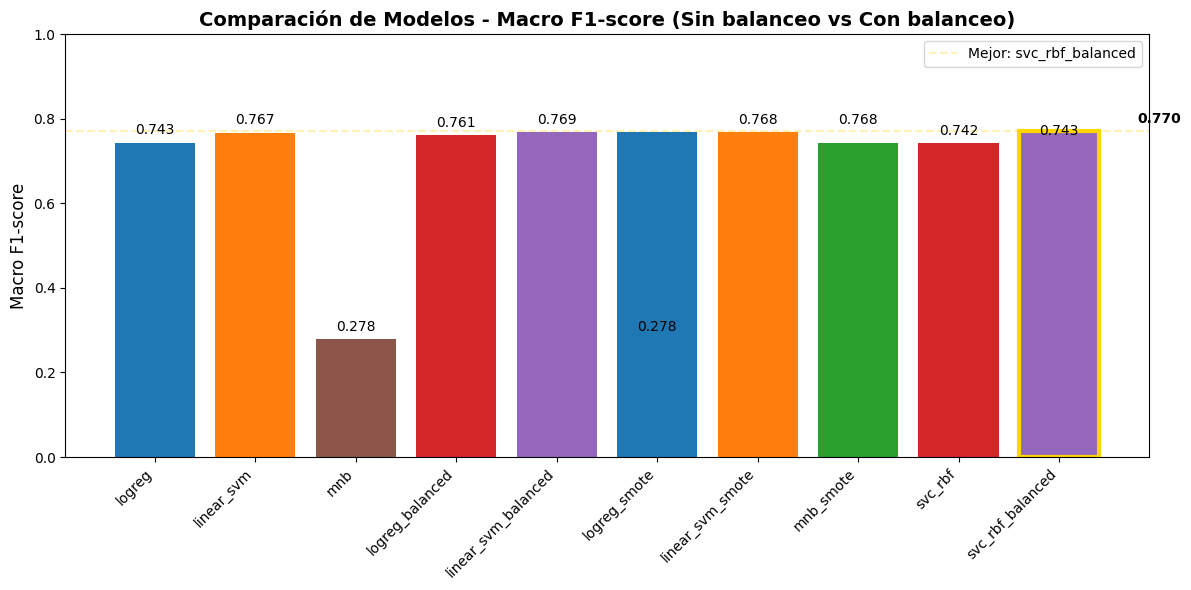

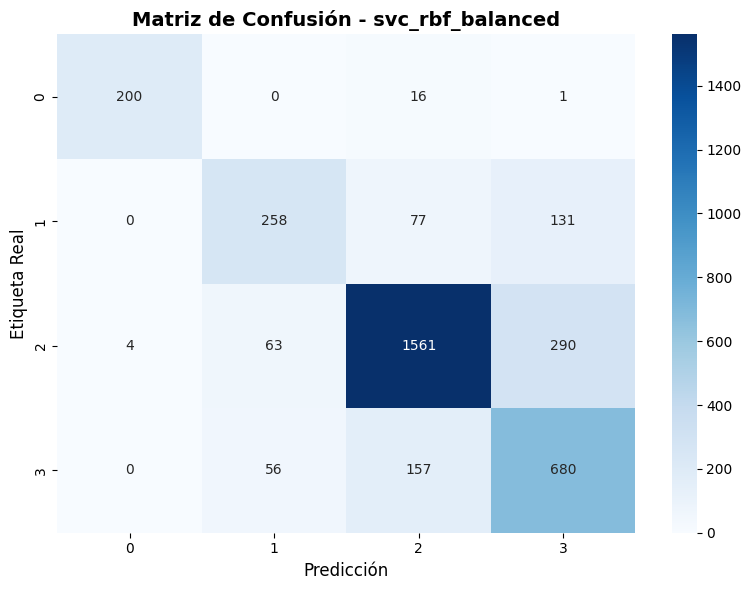

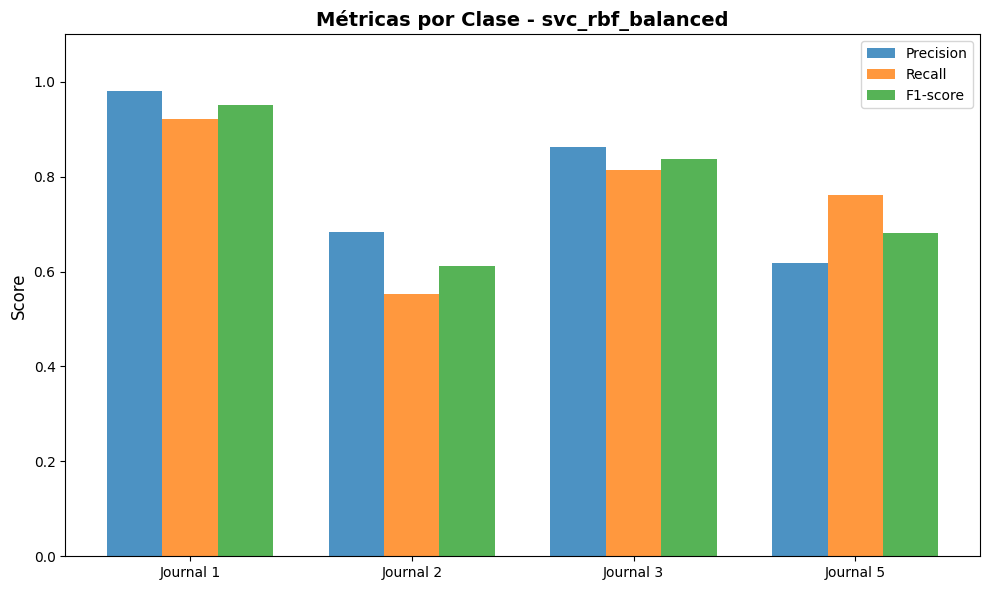

In [ ]:
# 1. Comparar Macro F1-score de modelos con y sin balanceo
fig, ax = plt.subplots(figsize=(12, 6))
all_models = list(results.keys()) + list(results_balanced.keys()) + list(results_smote.keys()) + list(results_svc.keys())
all_scores = [macro_f1(results[name]) if name in results else macro_f1(results_balanced[name] ) if name in results_balanced else macro_f1(results_smote[name]) if name in results_smote else macro_f1(results_svc[name])
              for name in all_models]
colors = ['#1f77b4', '#ff7f0e', '#2ca02c'] + ['#d62728', '#9467bd', '#8c564b']
bars = ax.bar(all_models, all_scores, color=colors)

# Mejor
best_idx = all_models.index(best_name)
bars[best_idx].set_edgecolor('gold')
bars[best_idx].set_linewidth(3)

ax.set_ylabel('Macro F1-score', fontsize=12)
ax.set_title('Comparación de Modelos - Macro F1-score (Sin balanceo vs Con balanceo)', 
             fontsize=14, fontweight='bold')
ax.set_ylim([0, 1])
ax.axhline(y=all_scores[best_idx], color='gold', linestyle='--', alpha=0.3, label=f'Mejor: {best_name}')
for i, v in enumerate(all_scores):
    ax.text(i, v + 0.02, f'{v:.3f}', ha='center', fontweight='bold' if i == best_idx else 'normal')
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.tight_layout()
plt.show()

# 2. Matriz de confusión del mejor modelo
fig, ax = plt.subplots(figsize=(8, 6))
cm = all_results[best_name]["cm"]
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax, cbar=True)
ax.set_title(f'Matriz de Confusión - {best_name}', fontsize=14, fontweight='bold')
ax.set_ylabel('Etiqueta Real', fontsize=12)
ax.set_xlabel('Predicción', fontsize=12)
plt.tight_layout()
plt.show()

# 3. Precision, Recall y F1-score por clase del mejor modelo
fig, ax = plt.subplots(figsize=(10, 6))
report = all_results[best_name]["report"]
metrics_data = {}
for class_id in sorted(set(y_test)):
    class_str = str(class_id)
    if class_str in report:
        metrics_data[class_str] = {
            'precision': report[class_str]['precision'],
            'recall': report[class_str]['recall'],
            'f1-score': report[class_str]['f1-score']
        }

x = np.arange(len(metrics_data))
width = 0.25
precision = [metrics_data[k]['precision'] for k in sorted(metrics_data.keys())]
recall = [metrics_data[k]['recall'] for k in sorted(metrics_data.keys())]
f1 = [metrics_data[k]['f1-score'] for k in sorted(metrics_data.keys())]

ax.bar(x - width, precision, width, label='Precision', alpha=0.8)
ax.bar(x, recall, width, label='Recall', alpha=0.8)
ax.bar(x + width, f1, width, label='F1-score', alpha=0.8)
ax.set_ylabel('Score', fontsize=12)
ax.set_title(f'Métricas por Clase - {best_name}', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels([f'Journal {k}' for k in sorted(metrics_data.keys())])
ax.legend()
ax.set_ylim([0, 1.1])
plt.tight_layout()
plt.show()

# 4. Comparación del impacto del balanceo (si existe un modelo equivalente sin balanceo)
base_model = best_name.replace('_balanced', '')
if base_model in results and best_name in results_balanced:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # F1-score por clase sin balanceo
    report_unbalanced = results[base_model]["report"]
    f1_unbalanced = [report_unbalanced[str(c)]['f1-score'] 
                     for c in sorted(set(y_test)) if str(c) in report_unbalanced]
    
    # F1-score por clase con balanceo
    report_balanced = results_balanced[best_name]["report"]
    f1_balanced = [report_balanced[str(c)]['f1-score'] 
                   for c in sorted(set(y_test)) if str(c) in report_balanced]
    
    x = np.arange(len(f1_unbalanced))
    width = 0.35
    
    axes[0].bar(x - width/2, f1_unbalanced, width, label='Sin balanceo', alpha=0.8)
    axes[0].bar(x + width/2, f1_balanced, width, label='Con balanceo', alpha=0.8)
    axes[0].set_ylabel('F1-score')
    axes[0].set_title('Impacto del Balanceo por Clase')
    axes[0].set_xticks(x)
    axes[0].set_xticklabels([f'J{c}' for c in sorted(set(y_test))])
    axes[0].legend()
    axes[0].set_ylim([0, 1.1])
    
    # Mejora absoluta
    improvement = np.array(f1_balanced) - np.array(f1_unbalanced)
    colors_imp = ['green' if i > 0 else 'red' for i in improvement]
    axes[1].bar(x, improvement, color=colors_imp, alpha=0.7)
    axes[1].axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    axes[1].set_ylabel('Cambio en F1-score')
    axes[1].set_title('Mejora con Balanceo')
    axes[1].set_xticks(x)
    axes[1].set_xticklabels([f'J{c}' for c in sorted(set(y_test))])
    
    for i, v in enumerate(improvement):
        axes[1].text(i, v + 0.02 if v > 0 else v - 0.05, f'{v:+.3f}', 
                    ha='center', fontweight='bold')
    
    plt.tight_layout()
    plt.show()

## Guardar artefactos: métricas + errores (CSV)

Este bloque de código se enfoca en la exportación de resultados detallados y análisis de errores a un directorio específico (`../docs/sklearn`) para propósitos de documentación y depuración.

In [ ]:
OUT_DIR = Path("../docs/sklearn")
OUT_DIR.mkdir(parents=True, exist_ok=True)

# Guardar métricas (JSON)
metrics = {
    "best_model": best_name,
    "all_models_macro_f1": {k: macro_f1(v) for k, v in results.items()},
}
with open(OUT_DIR / "metrics_summary.json", "w", encoding="utf-8") as f:
    json.dump(metrics, f, ensure_ascii=False, indent=2)

# Errores del mejor modelo
y_pred_best = best.predict(X_test)

errors = df.iloc[idx_test].copy()
errors["y_true"] = y_test
errors["y_pred"] = y_pred_best
errors = errors[errors["y_true"] != errors["y_pred"]]

errors.to_csv(OUT_DIR / "errors_best_model.csv", index=False)
errors.shape, (OUT_DIR / "errors_best_model.csv")

((795, 11), WindowsPath('../docs/sklearn/errors_best_model.csv'))